In [1]:
from Utils.DataPreprocessing import split_data, data_cleaning, glove_embedding
import torch
from torch import nn
from torch.utils.data import IterableDataset, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe, vocab, build_vocab_from_iterator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
from torch.nn import functional as F

In [2]:
random_seed = 0
training_set_size = 0.8
GLOVE_TXT_PATH = '../../GloVe Embeddings/glove.840B.300d.txt'
MAX_TOKEN_NBS = 1500 # max number of tokens in each review

In [3]:
imdb_data = pd.read_csv('Data/IMDB Dataset.csv')
imdb_data = data_cleaning(imdb_data)
train_set, test_set = split_data(imdb_data, training_set_size, random_seed)

/mnt/i/Projects/evaluation-deeplearning-NLP/Utils/DataPreprocessing.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['review'] = dataset['review'].str.replace('<.*?>', '')


In [4]:
train_set.describe()

,sentiment
count,40000.000000
mean,0.500875
std,0.500005
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
test_set.describe()

,sentiment
count,10000.000000
mean,0.496500
std,0.500013
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = '840B', cache = './.vector_cache')
else:
    glove_vectors = GloVe('840B')

In [7]:
glove_vectors

In [8]:
pad_token = "<pad>"
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>", 0)
# This is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(0)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

In [9]:
tokenizer = get_tokenizer("basic_english")

class MyDataset(Dataset):
    def __init__(self, dataframe, max_len=1500, pad_token='<pad>'):
         self.X = dataframe['review'].values
         self.Y = dataframe['sentiment'].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]
        diff = self.max_len - len(tokens)
        if diff > 0:
            tokens =  tokens + [self.pad_token] * diff
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result

In [10]:
train_dataset = MyDataset(train_set, MAX_TOKEN_NBS)
test_dataset = MyDataset(test_set, MAX_TOKEN_NBS)

In [11]:
for idx, data in enumerate(train_dataset):
    print("---------------------------------")
    print('next example id ', idx)
    example_text = data['text']
    print(example_text)
    print(data['labels'])
    break


---------------------------------
next example id  0
['that', 'is', 'about', 'the', 'only', 'redeeming', 'quality', 'in', 'a', 'movie', 'that', 'otherwise', 'insults', 'the', 'viewer', "'", 's', 'intelligence', 'by', 'losing', 'track', 'of', 'time', ',', 'plot', ',', 'and', 'reason', 'for', 'being', 'produced', '.', 'plus', ',', 'how', 'that', 'guy', 'with', 'the', 'glasses', 'ever', 'got', 'a', 'gig', 'in', 'hollywood', 'is', 'beyond', 'me', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [12]:
class TextClassificationModel(nn.Module):
    def __init__(self, pretrained_embeddings, num_class,  freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)
        self.conv3 = nn.Conv2d(1, 1, (5, 300))
        self.conv4 = nn.Conv2d(1, 1, (6, 300))
        self.conv5 = nn.Conv2d(1, 1, (7, 300))

        self.Max3_pool = nn.MaxPool2d((1500-5+1, 1))
        self.Max4_pool = nn.MaxPool2d((1500-6+1, 1))
        self.Max5_pool = nn.MaxPool2d((1500-7+1, 1))

        self.linear1 = nn.Linear(3, num_class)


    def forward(self, indices):

        batch = indices.shape[0]

        x = self.embedding(indices.T)
        x = x[None, :]

        x = x.permute(2,0,1,3)

        # Convolution
        x1 = F.relu(self.conv3(x))
        x2 = F.relu(self.conv4(x))
        x3 = F.relu(self.conv5(x))


        # Pooling
        x1 = self.Max3_pool(x1)
        x2 = self.Max4_pool(x2)
        x3 = self.Max5_pool(x3)


        x = torch.cat((x1, x2, x3), -1)
        x = x.view(batch, 1, -1)
        out = self.linear1(x)

        return out

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1024

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

Epoch: 0 Train_Loss: 0.6765399485826492 Train_Accuracy: 0.499625
Epoch: 0 Test_Loss: 0.6585768342018128 Test_Accuracy: 0.5048


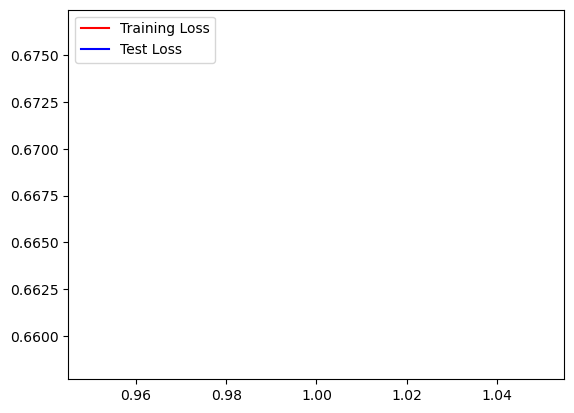

Epoch: 1 Train_Loss: 0.6382417097687721 Train_Accuracy: 0.52995
Epoch: 1 Test_Loss: 0.6202052593231201 Test_Accuracy: 0.5396


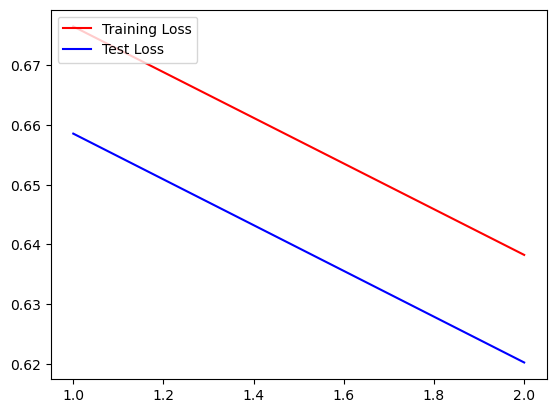

Epoch: 2 Train_Loss: 0.5955849096179009 Train_Accuracy: 0.58375
Epoch: 2 Test_Loss: 0.5876844525337219 Test_Accuracy: 0.6163


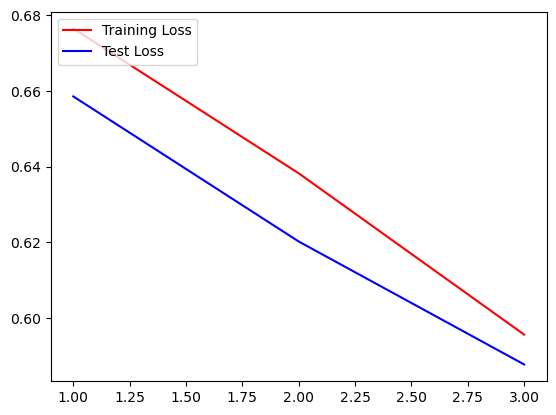

Epoch: 3 Train_Loss: 0.5705411344766617 Train_Accuracy: 0.638275
Epoch: 3 Test_Loss: 0.5725077569484711 Test_Accuracy: 0.6398


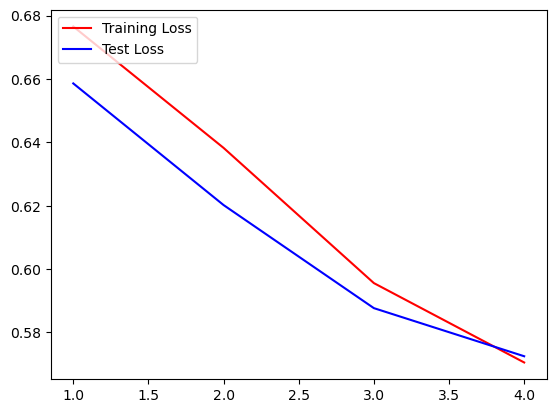

Epoch: 4 Train_Loss: 0.5555214628577232 Train_Accuracy: 0.670675
Epoch: 4 Test_Loss: 0.5593666076660156 Test_Accuracy: 0.6656


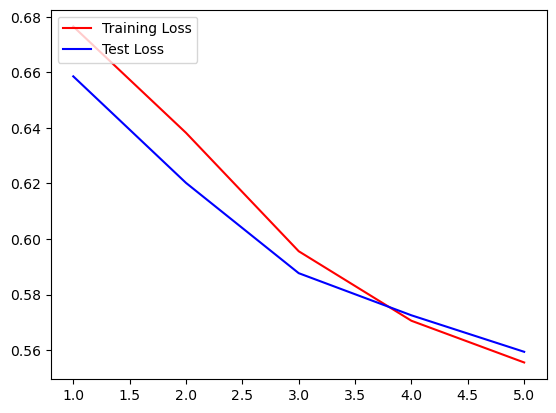

Epoch: 5 Train_Loss: 0.5394549466669559 Train_Accuracy: 0.693875
Epoch: 5 Test_Loss: 0.5470742166042328 Test_Accuracy: 0.6789


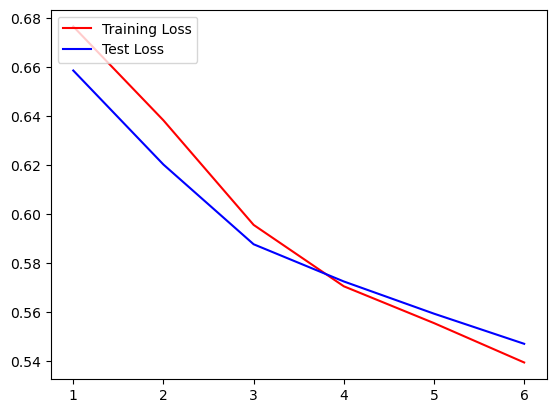

Epoch: 6 Train_Loss: 0.5241473890841007 Train_Accuracy: 0.7086
Epoch: 6 Test_Loss: 0.5365733087062836 Test_Accuracy: 0.7079


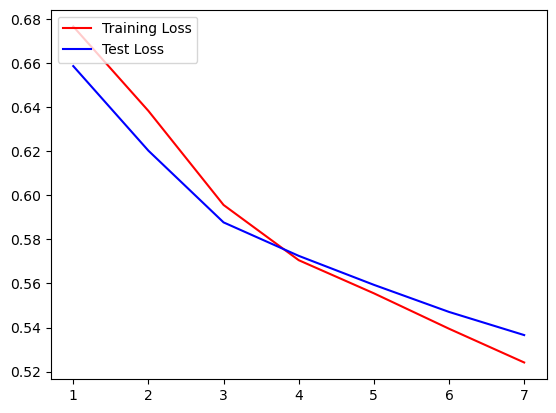

Epoch: 7 Train_Loss: 0.5124857351183891 Train_Accuracy: 0.72305
Epoch: 7 Test_Loss: 0.527828186750412 Test_Accuracy: 0.7058


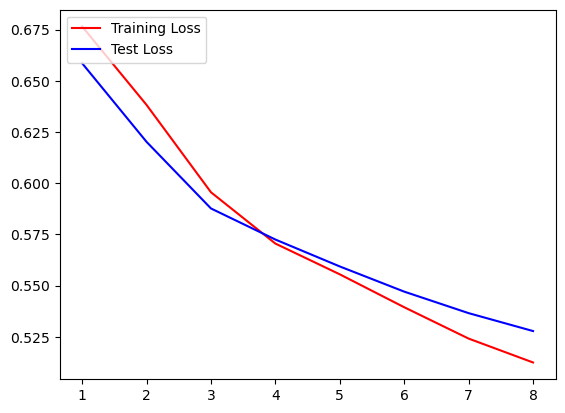

Epoch: 8 Train_Loss: 0.5027939736843109 Train_Accuracy: 0.73105
Epoch: 8 Test_Loss: 0.5223557740449906 Test_Accuracy: 0.718


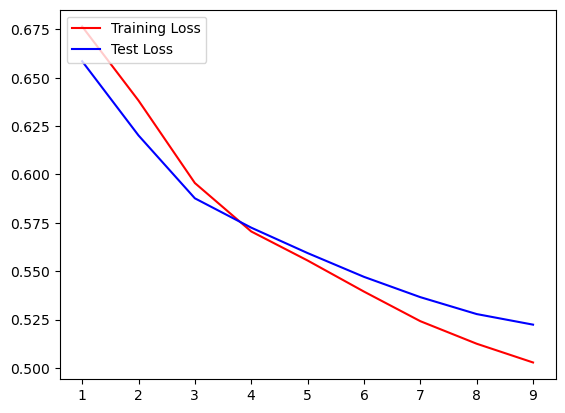

Epoch: 9 Train_Loss: 0.49276039749383926 Train_Accuracy: 0.74105
Epoch: 9 Test_Loss: 0.5165750503540039 Test_Accuracy: 0.7181


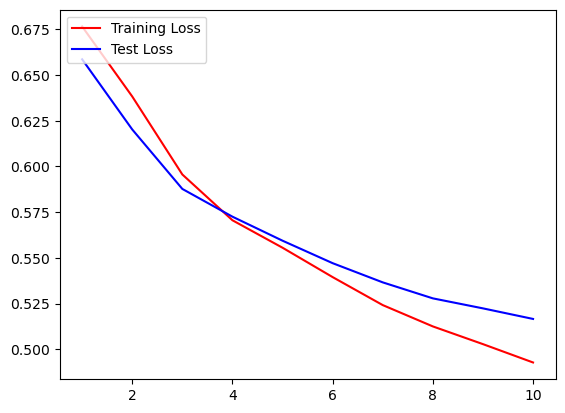

Epoch: 10 Train_Loss: 0.48489765971899035 Train_Accuracy: 0.747125
Epoch: 10 Test_Loss: 0.5138684391975403 Test_Accuracy: 0.7331


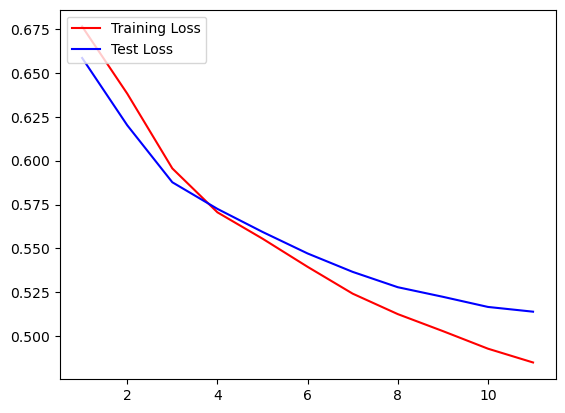

Epoch: 11 Train_Loss: 0.4776597827672958 Train_Accuracy: 0.752375
Epoch: 11 Test_Loss: 0.5086909532546997 Test_Accuracy: 0.7346


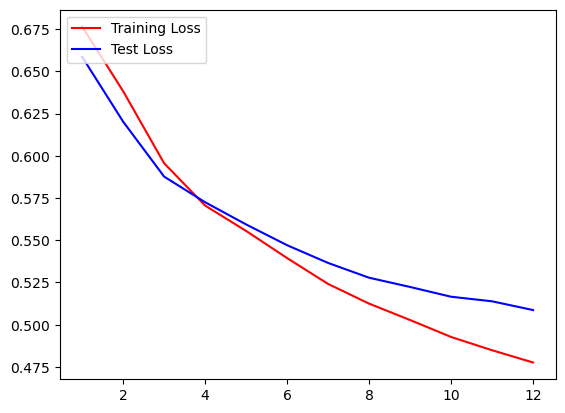

Epoch: 12 Train_Loss: 0.47125912085175514 Train_Accuracy: 0.7583
Epoch: 12 Test_Loss: 0.5060672372579574 Test_Accuracy: 0.7346


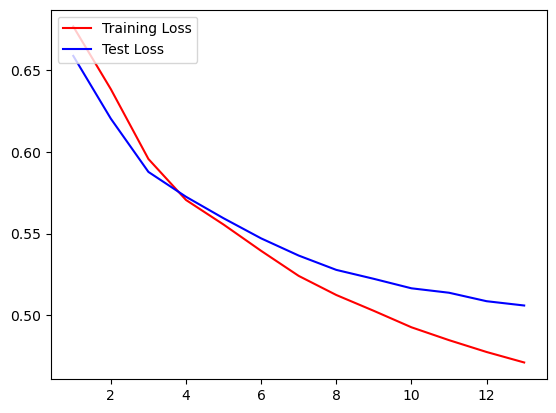

Epoch: 13 Train_Loss: 0.4652557231485844 Train_Accuracy: 0.76225
Epoch: 13 Test_Loss: 0.503470292687416 Test_Accuracy: 0.7297


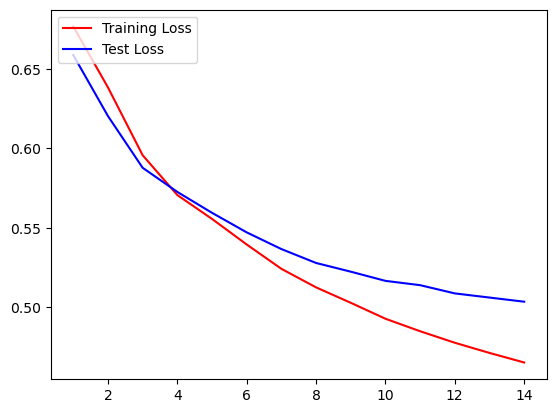

Epoch: 14 Train_Loss: 0.4625689394772053 Train_Accuracy: 0.76475
Epoch: 14 Test_Loss: 0.5015670955181122 Test_Accuracy: 0.7274


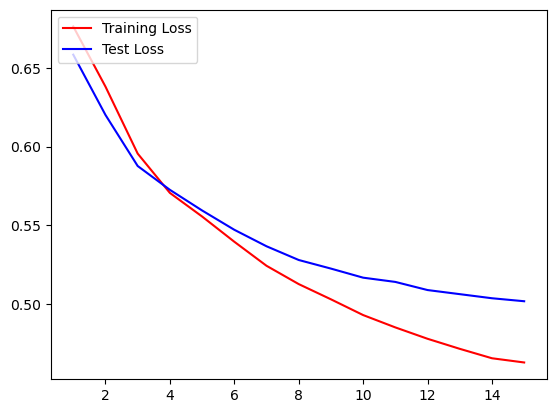

Epoch: 15 Train_Loss: 0.4598040714859962 Train_Accuracy: 0.7689
Epoch: 15 Test_Loss: 0.49922296702861785 Test_Accuracy: 0.7367


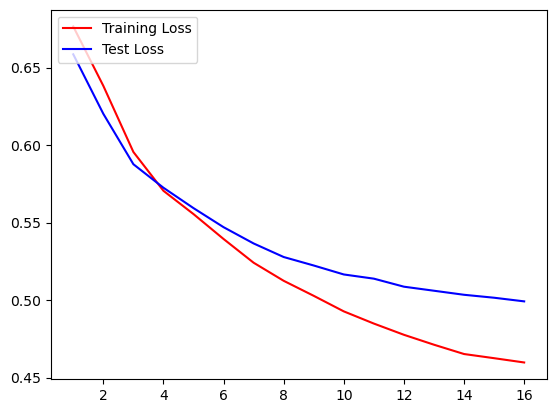

Epoch: 16 Train_Loss: 0.45427302941679953 Train_Accuracy: 0.7719
Epoch: 16 Test_Loss: 0.4984033524990082 Test_Accuracy: 0.7307


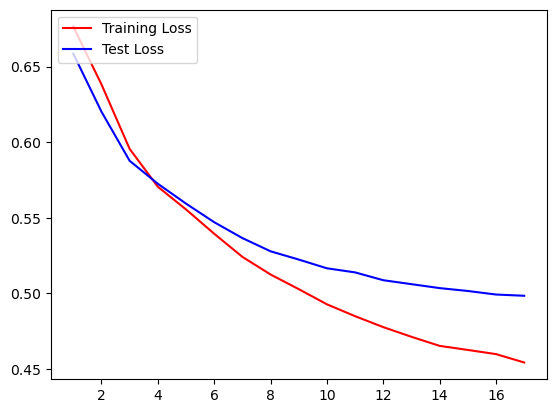

Epoch: 17 Train_Loss: 0.45124520510435107 Train_Accuracy: 0.77445
Epoch: 17 Test_Loss: 0.4955614238977432 Test_Accuracy: 0.7392


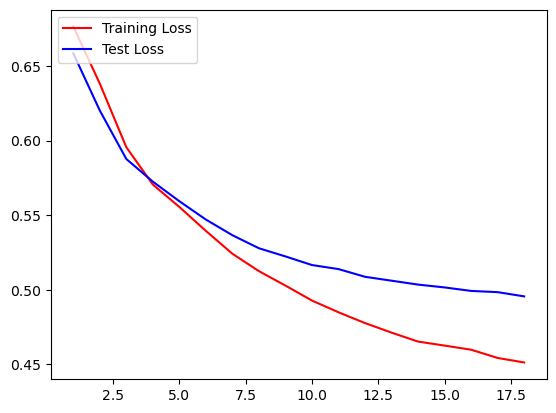

Epoch: 18 Train_Loss: 0.4482505485415459 Train_Accuracy: 0.776975
Epoch: 18 Test_Loss: 0.4937825709581375 Test_Accuracy: 0.7426


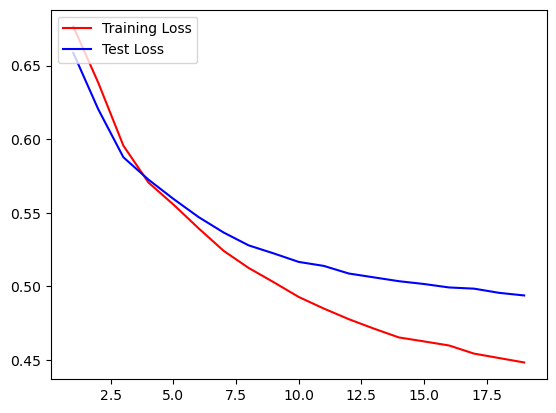

Epoch: 19 Train_Loss: 0.442475862801075 Train_Accuracy: 0.780475
Epoch: 19 Test_Loss: 0.49272450506687165 Test_Accuracy: 0.7344


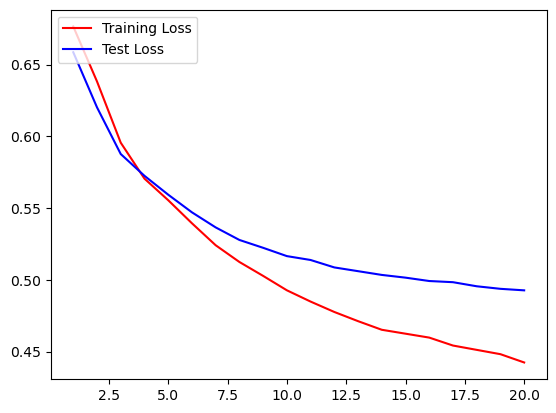

Epoch: 20 Train_Loss: 0.4388566315174103 Train_Accuracy: 0.782175
Epoch: 20 Test_Loss: 0.49130440354347227 Test_Accuracy: 0.7442


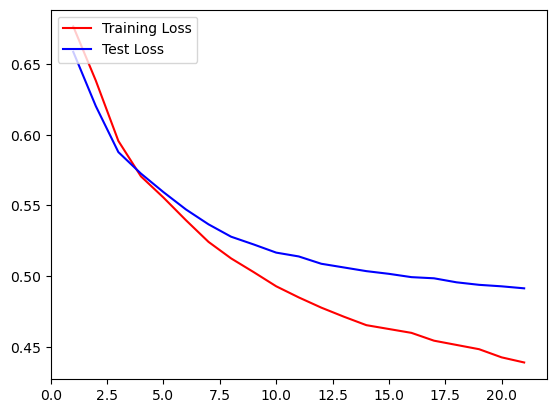

Epoch: 21 Train_Loss: 0.43634413108229636 Train_Accuracy: 0.784
Epoch: 21 Test_Loss: 0.48919807374477386 Test_Accuracy: 0.75


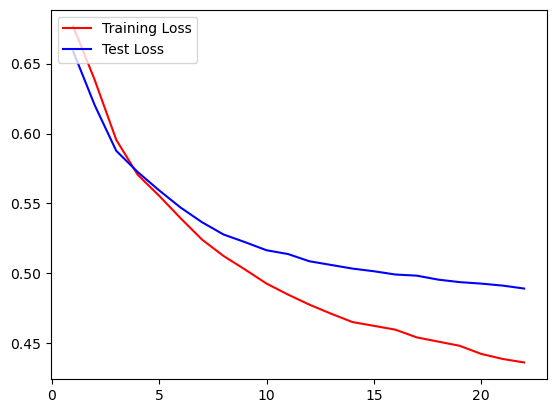

Epoch: 22 Train_Loss: 0.4331979647278786 Train_Accuracy: 0.78625
Epoch: 22 Test_Loss: 0.4887265145778656 Test_Accuracy: 0.7496


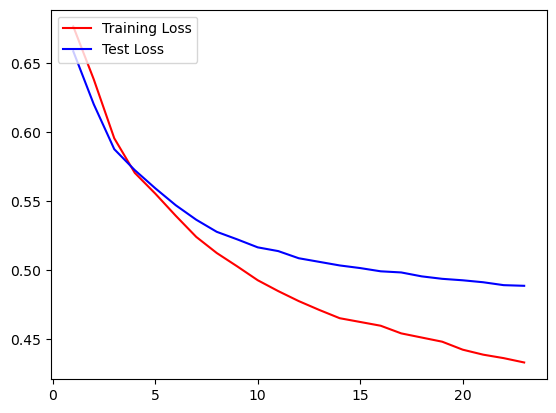

Epoch: 23 Train_Loss: 0.4318283677101135 Train_Accuracy: 0.78895
Epoch: 23 Test_Loss: 0.4876438915729523 Test_Accuracy: 0.7422


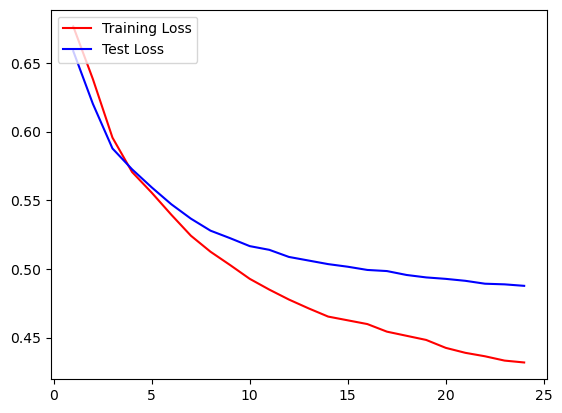

Epoch: 24 Train_Loss: 0.4295750245451927 Train_Accuracy: 0.79005
Epoch: 24 Test_Loss: 0.48679203987121583 Test_Accuracy: 0.7436


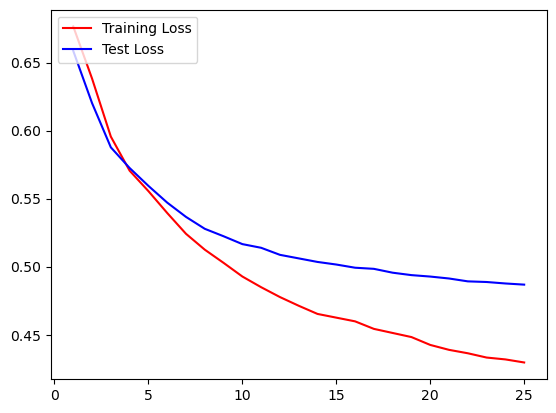

Epoch: 25 Train_Loss: 0.42550531178712847 Train_Accuracy: 0.7915
Epoch: 25 Test_Loss: 0.4867610394954681 Test_Accuracy: 0.7513


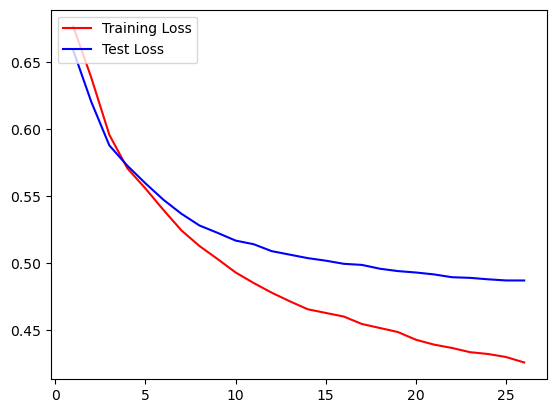

Epoch: 26 Train_Loss: 0.42344778329133986 Train_Accuracy: 0.794625
Epoch: 26 Test_Loss: 0.4849709004163742 Test_Accuracy: 0.7476


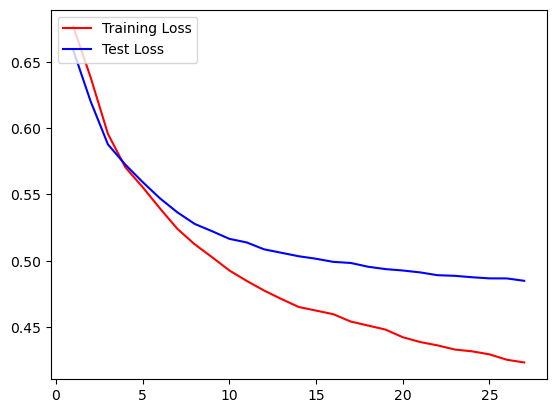

Epoch: 27 Train_Loss: 0.4196333780884743 Train_Accuracy: 0.794925
Epoch: 27 Test_Loss: 0.484777694940567 Test_Accuracy: 0.7458


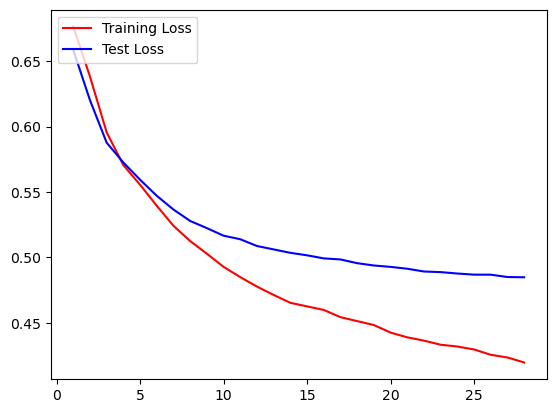

Epoch: 28 Train_Loss: 0.4161669500172138 Train_Accuracy: 0.797
Epoch: 28 Test_Loss: 0.4841442286968231 Test_Accuracy: 0.7485


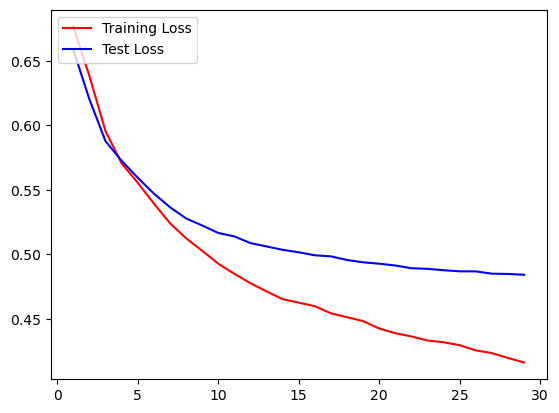

Epoch: 29 Train_Loss: 0.4146960288286209 Train_Accuracy: 0.798625
Epoch: 29 Test_Loss: 0.4831193834543228 Test_Accuracy: 0.7498


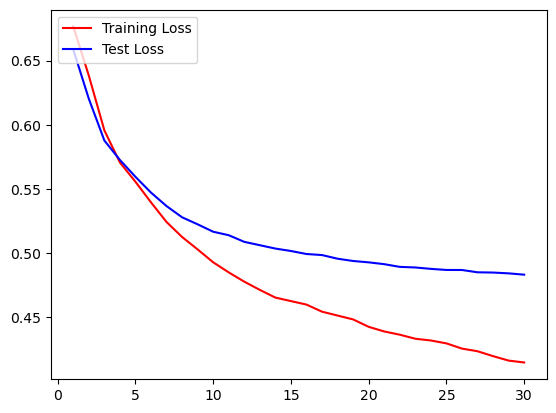

Epoch: 30 Train_Loss: 0.41135355457663536 Train_Accuracy: 0.79835
Epoch: 30 Test_Loss: 0.48317146897315977 Test_Accuracy: 0.7488


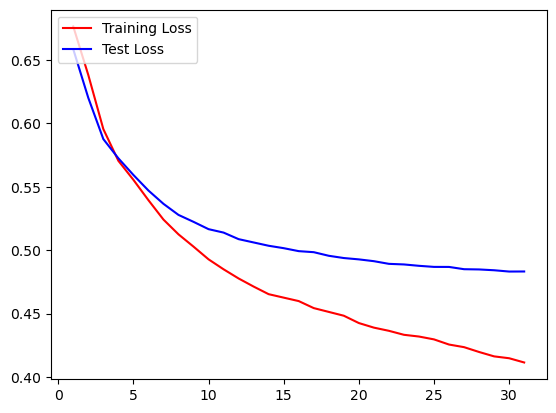

Epoch: 31 Train_Loss: 0.4099636130034924 Train_Accuracy: 0.802775
Epoch: 31 Test_Loss: 0.48198657631874087 Test_Accuracy: 0.7535


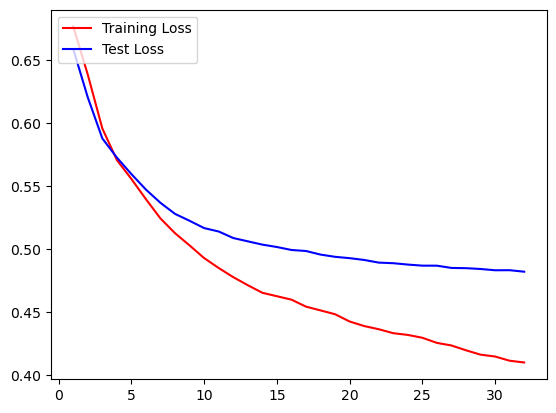

Epoch: 32 Train_Loss: 0.4094769775867462 Train_Accuracy: 0.803975
Epoch: 32 Test_Loss: 0.48267737329006194 Test_Accuracy: 0.7485


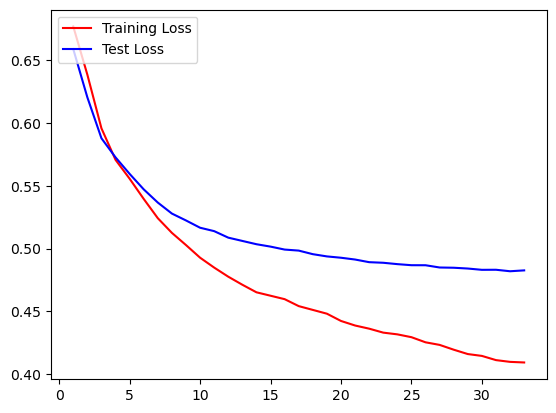

Epoch: 33 Train_Loss: 0.4082940973341465 Train_Accuracy: 0.80375
Epoch: 33 Test_Loss: 0.4829288572072983 Test_Accuracy: 0.7482


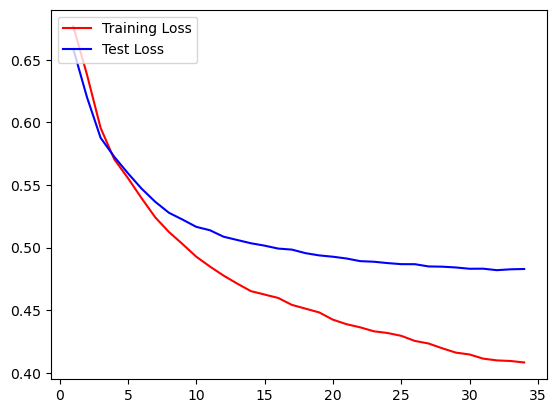

Epoch: 34 Train_Loss: 0.40688410103321077 Train_Accuracy: 0.803875
Epoch: 34 Test_Loss: 0.4814519762992859 Test_Accuracy: 0.7573


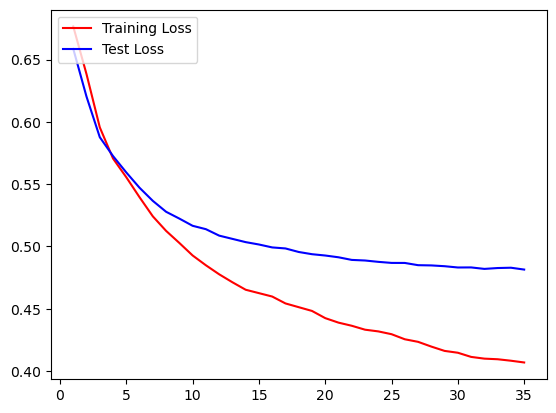

Epoch: 35 Train_Loss: 0.40330474749207496 Train_Accuracy: 0.807725
Epoch: 35 Test_Loss: 0.4807443469762802 Test_Accuracy: 0.753


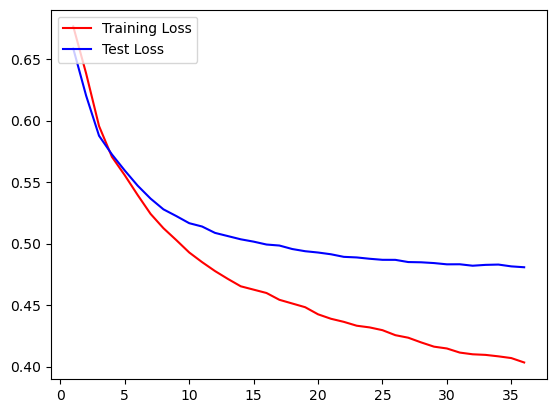

Epoch: 36 Train_Loss: 0.3991611547768116 Train_Accuracy: 0.8084
Epoch: 36 Test_Loss: 0.4800651490688324 Test_Accuracy: 0.7556


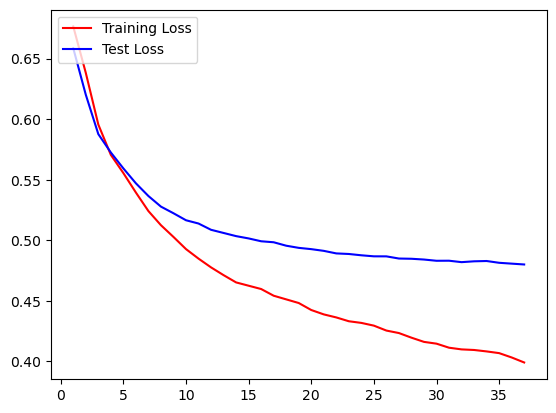

Epoch: 37 Train_Loss: 0.39900962859392164 Train_Accuracy: 0.8086
Epoch: 37 Test_Loss: 0.47957385182380674 Test_Accuracy: 0.7578


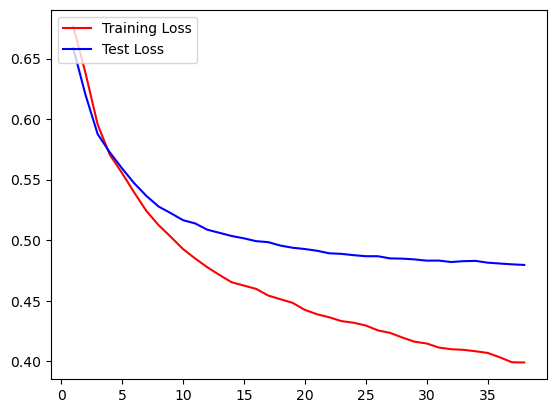

Epoch: 38 Train_Loss: 0.39697774052619933 Train_Accuracy: 0.810925
Epoch: 38 Test_Loss: 0.4808530151844025 Test_Accuracy: 0.7496


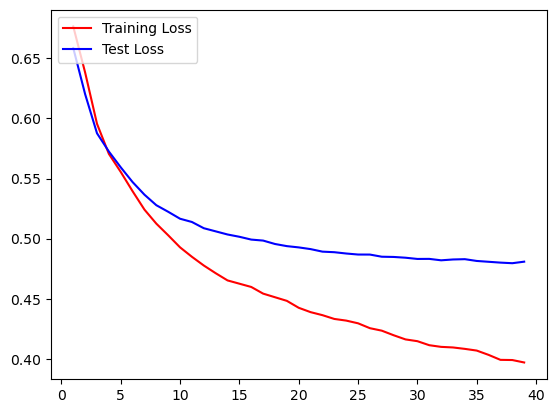

Epoch: 39 Train_Loss: 0.3967213124036789 Train_Accuracy: 0.81265
Epoch: 39 Test_Loss: 0.4788841247558594 Test_Accuracy: 0.7601


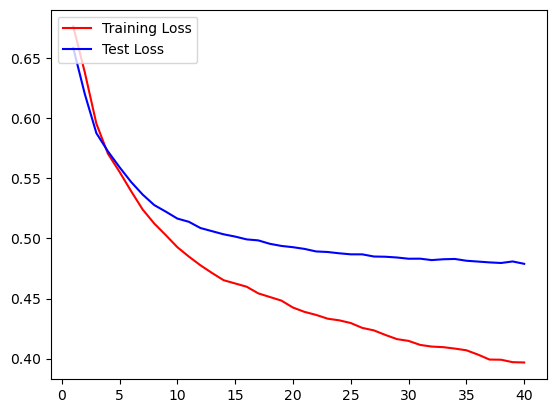

Epoch: 40 Train_Loss: 0.39690899178385736 Train_Accuracy: 0.813625
Epoch: 40 Test_Loss: 0.48067404627799987 Test_Accuracy: 0.7505


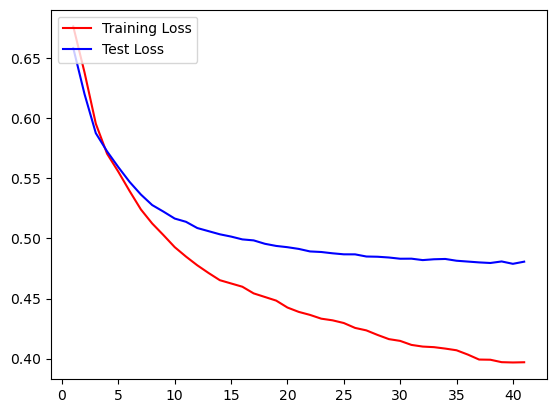

Epoch: 41 Train_Loss: 0.3929657764732838 Train_Accuracy: 0.813725
Epoch: 41 Test_Loss: 0.47885158360004426 Test_Accuracy: 0.7597


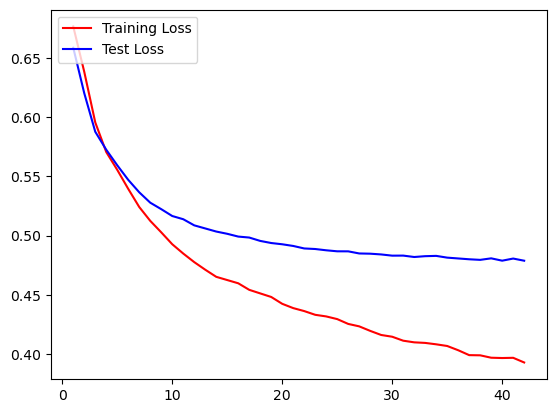

Epoch: 42 Train_Loss: 0.39175756499171255 Train_Accuracy: 0.814875
Epoch: 42 Test_Loss: 0.4786898076534271 Test_Accuracy: 0.7564


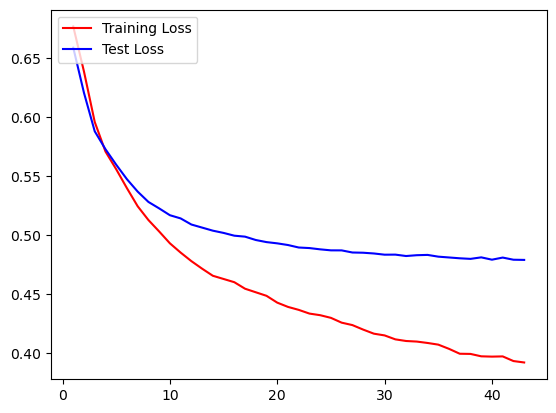

Epoch: 43 Train_Loss: 0.38752287402749064 Train_Accuracy: 0.816325
Epoch: 43 Test_Loss: 0.4784845560789108 Test_Accuracy: 0.7598


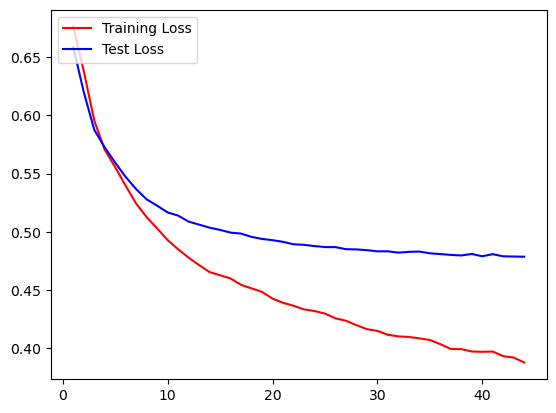

Epoch: 44 Train_Loss: 0.3904603712260723 Train_Accuracy: 0.8169
Epoch: 44 Test_Loss: 0.478061118721962 Test_Accuracy: 0.7595


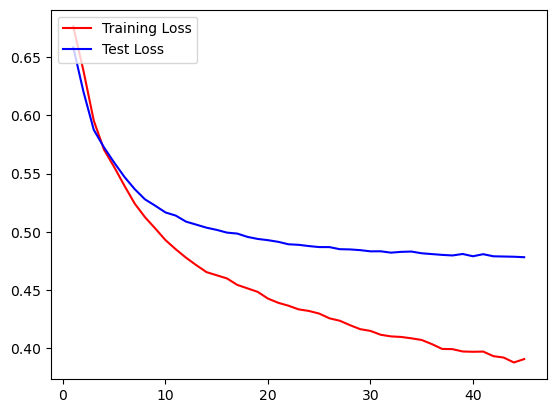

Epoch: 45 Train_Loss: 0.38548075333237647 Train_Accuracy: 0.81715
Epoch: 45 Test_Loss: 0.4788377612829208 Test_Accuracy: 0.7573


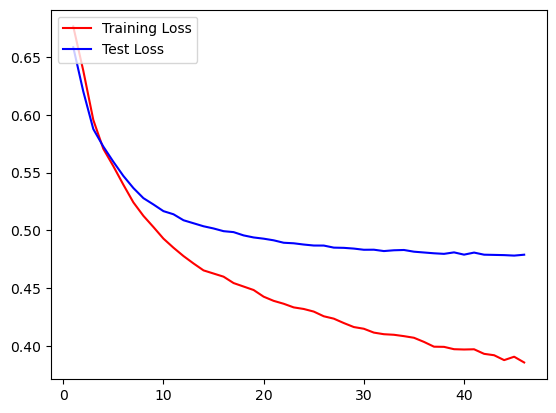

Epoch: 46 Train_Loss: 0.38610161021351813 Train_Accuracy: 0.81845
Epoch: 46 Test_Loss: 0.4790821701288223 Test_Accuracy: 0.7616


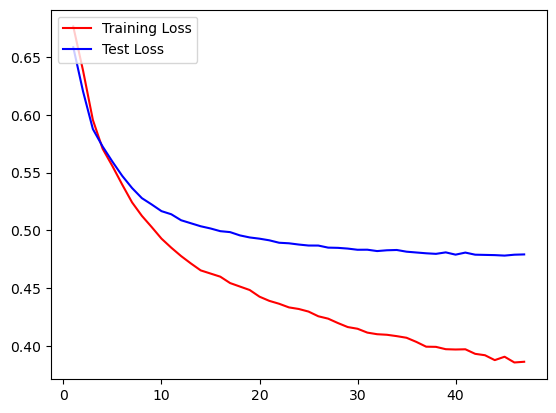

Epoch: 47 Train_Loss: 0.38413247242569926 Train_Accuracy: 0.820175
Epoch: 47 Test_Loss: 0.47890953719615936 Test_Accuracy: 0.759


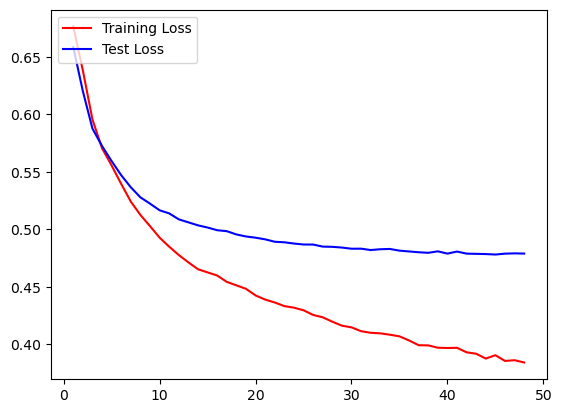

Epoch: 48 Train_Loss: 0.38199672996997835 Train_Accuracy: 0.820525
Epoch: 48 Test_Loss: 0.47852376401424407 Test_Accuracy: 0.7594


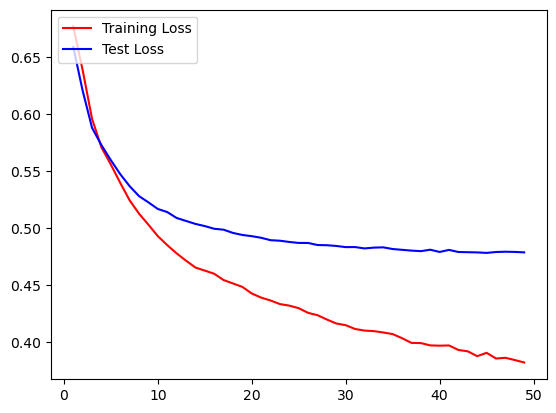

Epoch: 49 Train_Loss: 0.3813981875777245 Train_Accuracy: 0.820825
Epoch: 49 Test_Loss: 0.47963951528072357 Test_Accuracy: 0.7611


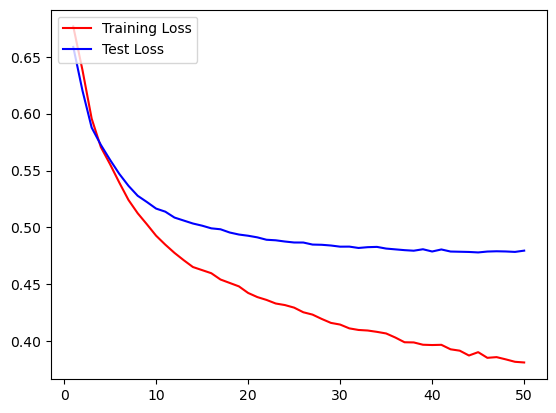

Epoch: 50 Train_Loss: 0.38049529418349265 Train_Accuracy: 0.821325
Epoch: 50 Test_Loss: 0.47923487722873687 Test_Accuracy: 0.7623


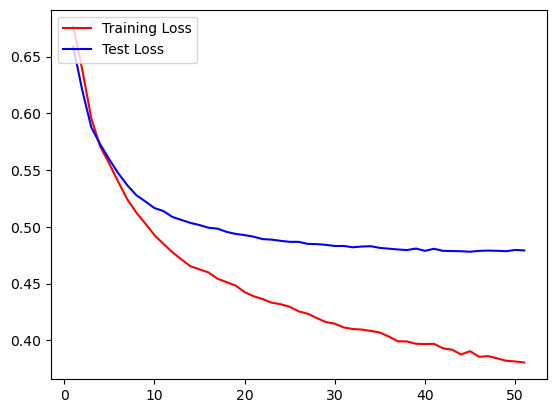

Epoch: 51 Train_Loss: 0.38129383251070975 Train_Accuracy: 0.8213
Epoch: 51 Test_Loss: 0.47897260785102846 Test_Accuracy: 0.758


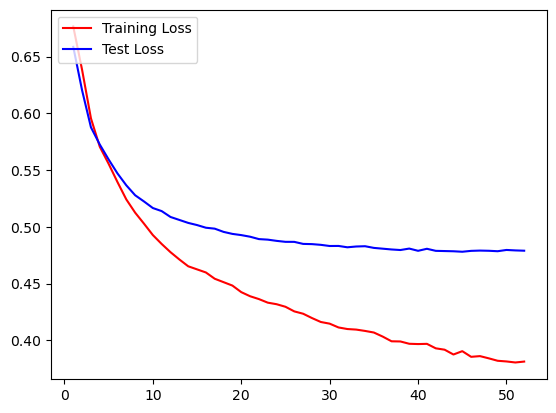

Epoch: 52 Train_Loss: 0.37601139917969706 Train_Accuracy: 0.82295
Epoch: 52 Test_Loss: 0.48009279668331145 Test_Accuracy: 0.7598


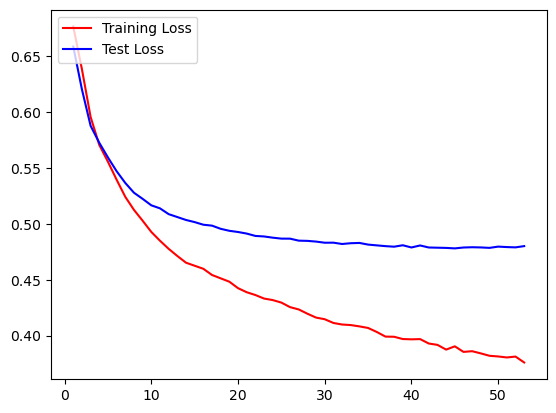

Epoch: 53 Train_Loss: 0.3791035436093807 Train_Accuracy: 0.82385
Epoch: 53 Test_Loss: 0.48005289435386655 Test_Accuracy: 0.758


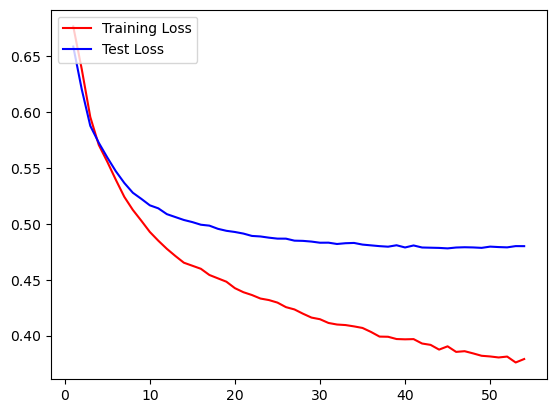

Epoch: 54 Train_Loss: 0.3748663529753685 Train_Accuracy: 0.8237
Epoch: 54 Test_Loss: 0.48073079288005827 Test_Accuracy: 0.7597


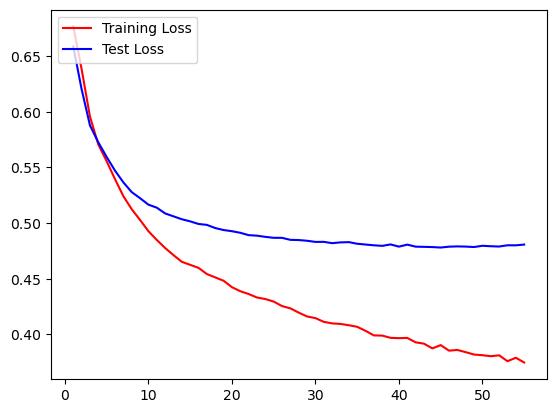

Epoch: 55 Train_Loss: 0.37426873818039896 Train_Accuracy: 0.8252
Epoch: 55 Test_Loss: 0.48015054166316984 Test_Accuracy: 0.7603


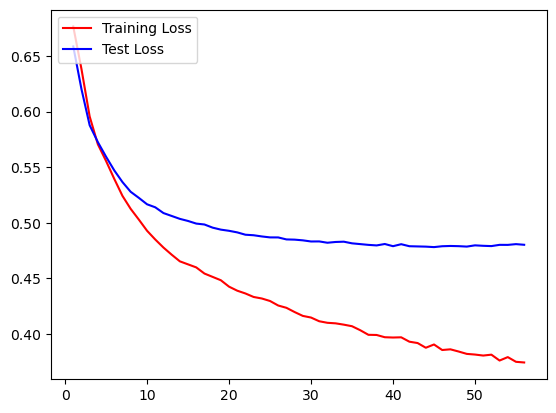

Epoch: 56 Train_Loss: 0.37475294396281245 Train_Accuracy: 0.82585
Epoch: 56 Test_Loss: 0.4813426673412323 Test_Accuracy: 0.7576


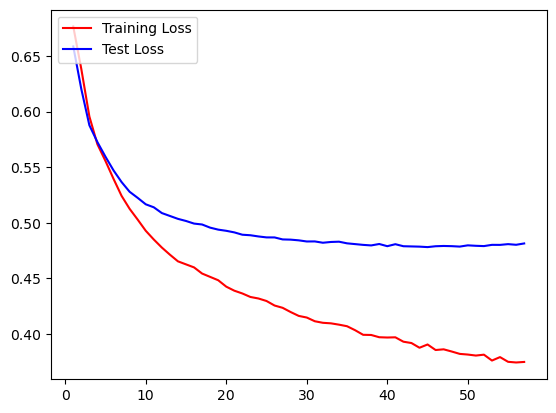

Epoch: 57 Train_Loss: 0.37122499048709867 Train_Accuracy: 0.826975
Epoch: 57 Test_Loss: 0.48286381661891936 Test_Accuracy: 0.7554


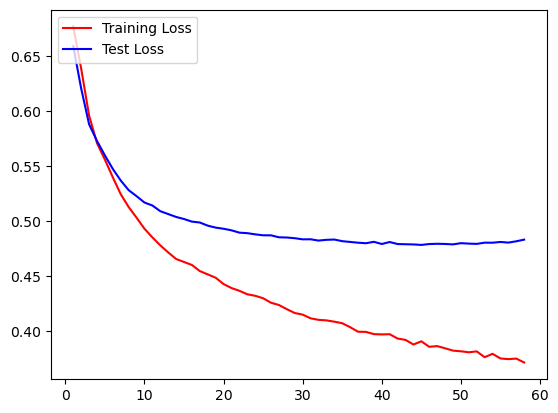

Epoch: 58 Train_Loss: 0.3692634247243404 Train_Accuracy: 0.826075
Epoch: 58 Test_Loss: 0.4816176354885101 Test_Accuracy: 0.7596


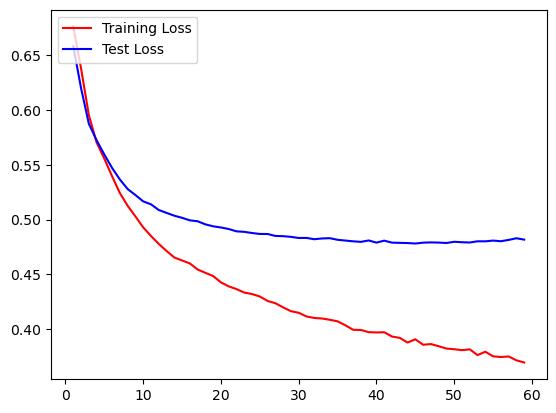

KeyboardInterrupt: 

In [15]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
model = TextClassificationModel(pretrained_embeddings, 1)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=8e-4, weight_decay=0.0001)

epochs = 500

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    train_predictions_store = []
    train_labels_store = []
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        outputs = torch.reshape(outputs, (-1,))
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)

        labels = labels.to(torch.device("cpu")).numpy()
        preds = preds.to(torch.device("cpu")).numpy()
        for i in range(len(preds)):
            train_predictions_store.append(preds[i])
            train_labels_store.append(labels[i])

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = accuracy_score(train_labels_store, train_predictions_store)

    #  rp = classification_report(train_labels_store, train_predictions_store, target_names=['0','1'])
    #  print(rp)



    torch.save(model.state_dict(), 'Models/CNN_model_epoch_{}.pt'.format(e))

    # Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        test_predictions_store = []
        test_labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)
            outputs = torch.reshape(outputs, (-1,))

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                test_predictions_store.append(preds[i])
                test_labels_store.append(labels[i])

        test_loss = np.mean(test_loss)
        test_accuracy = accuracy_score(test_labels_store, test_predictions_store)
        test_losses[e] = test_loss

        #rp = classification_report(test_labels_store, test_predictions_store, target_names=['0','1'])
        #print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, test_accuracy))

        plt.plot(epoch_count, training_losses, 'r', label='Training Loss')
        plt.plot(epoch_count, test_losses, 'b', label='Test Loss')
        plt.legend(loc="upper left")

        plt.show()